In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
from symbolic_transfer_entropy import symbolic_transfer_entropy as ste
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import seaborn as sbs

# Loading Data

In [2]:
data_path = '/home/pranavgoel/trans-fer-entropy/keyword_extraction'

In [3]:
# time_ser_dicts is a dictionary consisting of pandas series where the index is the date and the value is 
# the number of trans-related articles from that day

time_ser_dicts = defaultdict(pd.Series)

for f in tqdm(os.listdir(data_path)):
    
    if '.pkl' in f:
        
        # giving this dictionary a name (key)
        name = f.split('_url')[0]
        print(name)
        
        # unpickling
        with open(data_path+'/'+f, 'rb') as p:
            d = pickle.load(p)
            
        # converting dates to datetime list
        dates = list()
        
        try: 
            dates = [datetime.strptime(v[0], '%Y-%m-%d %H:%M:%S') for v in d.values()]
        except ValueError:
            dates =  [datetime.strptime(v[0], '%Y-%m-%d %H:%M:%S.%f') for v in d.values()]
        
        # Convert the list of datetime values to a pandas Series
        datetime_series = pd.to_datetime(dates)

        # Create a time series of counts using pandas
        count_series = datetime_series.value_counts().sort_index()

        # You can also resample the time series to fill missing gaps if necessary
        # For example, resample to hourly counts:
        count_series = count_series.resample('D').count().fillna(0)
        
        # creating key,val pair of name and daily article volume
        time_ser_dicts[name] = count_series
        
    else: 
        pass

  0%|          | 0/10 [00:00<?, ?it/s]

florida
california
illinois
texas
newyork
ohio
nytimes_foxnews


# Fixed Delay Transfer Entropy

In [29]:
delay = 4

In [30]:
# creating an array of transfer entropies T_YX where X is the row and Y is the column

outlets = list(time_ser_dicts.keys())
T = np.zeros(shape=(len(outlets),len(outlets)))


for n, i in tqdm(enumerate(outlets)):
    x = list(time_ser_dicts.get(i).values)
    for m in range(n+1, len(outlets)):
        y = list(time_ser_dicts.get(outlets[m]).values)
        
        T[n, m] = ste(x,y,w=delay, s=1)
        T[m, n] = ste(y,x,w=delay, s=1)

0it [00:00, ?it/s]

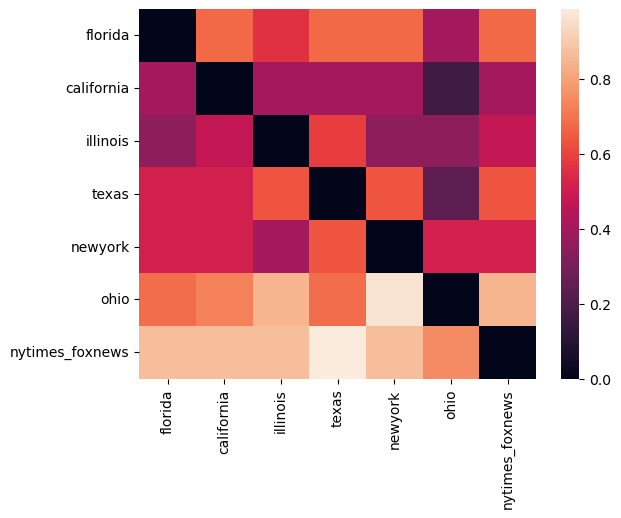

In [31]:
T_plot = sbs.heatmap(T, xticklabels=outlets, yticklabels=outlets)
fig = T_plot.get_figure()
#fig.savefig('/home/sagar/trans-fer-entropy/plots_and_images/article_volume_heat_raw_w4.pdf')

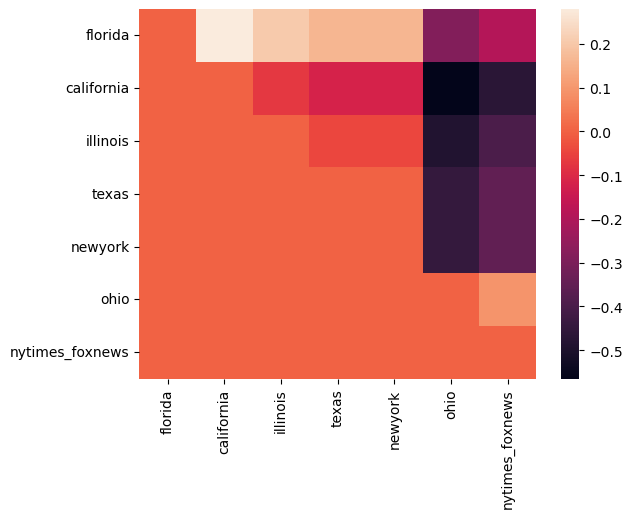

In [32]:
# directional matrix

dirT = np.zeros(T.shape)

for n in range(T.shape[0]):
    for m in range(n, T.shape[1]):
        
        dirT[n,m] = T[n,m] - T[m,n]
        #dirT[m,n] = T[m,n] - T[n,m]
        
dirT_plot = sbs.heatmap(dirT, xticklabels=outlets, yticklabels=outlets)
fig = dirT_plot.get_figure()
#fig.savefig('/home/sagar/trans-fer-entropy/plots_and_images/article_volume_heat_directional_w4.pdf')